VERSIÓN MEJORADA FINAL 20-04-25

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2

import kagglehub


In [ ]:
# ============================
# DESCARGA DEL DATASET
# ============================
datasource_path_completo = kagglehub.dataset_download('abdallahalidev/plantvillage-dataset')
dataset_path = os.path.join(datasource_path_completo, 'plantvillage dataset/color')


In [ ]:

# ============================
# DIVIDIR EL DATASET EN CARPETAS
# ============================
import shutil
from tqdm import tqdm

def split_dataset(base_path, output_path, train_split=0.7, val_split=0.15, test_split=0.15):
    os.makedirs(output_path, exist_ok=True)
    for split in ['train', 'val', 'test']:
        os.makedirs(os.path.join(output_path, split), exist_ok=True)

    classes = os.listdir(base_path)
    for class_name in tqdm(classes, desc="Dividiendo clases"):
        class_path = os.path.join(base_path, class_name)
        images = os.listdir(class_path)
        np.random.shuffle(images)

        n_total = len(images)
        n_train = int(n_total * train_split)
        n_val = int(n_total * val_split)

        for i, img in enumerate(images):
            if i < n_train:
                split = 'train'
            elif i < n_train + n_val:
                split = 'val'
            else:
                split = 'test'

            split_dir = os.path.join(output_path, split, class_name)
            os.makedirs(split_dir, exist_ok=True)
            shutil.copy(os.path.join(class_path, img), os.path.join(split_dir, img))

split_dataset(dataset_path, "dataset_dividido")


Dividiendo clases: 100%|██████████| 38/38 [06:52<00:00, 10.86s/it]


In [ ]:

# ================================
# PARÁMETROS Y PREPROCESAMIENTO
# ================================
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    "dataset_dividido/train",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = datagen.flow_from_directory(
    "dataset_dividido/val",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    "dataset_dividido/test",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

num_classes = len(train_generator.class_indices)


Found 37997 images belonging to 38 classes.
Found 8129 images belonging to 38 classes.
Found 8179 images belonging to 38 classes.


In [ ]:

# =====================
# CLASS WEIGHTS
# =====================
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))


In [ ]:

# ============================
# DEFINICIÓN DEL MODELO CNN
# ============================
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001), input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    GlobalAveragePooling2D(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:

# ========================
# CALLBACKS
# ========================
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
checkpoint = ModelCheckpoint("mejor_modelo.h5", save_best_only=True, monitor="val_loss")

# ========================
# ENTRENAMIENTO
# ========================
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stop, reduce_lr, checkpoint],
    class_weight=class_weights
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.3957 - auc: 0.9031 - loss: 2.4818 - precision: 0.7162 - recall: 0.1860

1188/1188 ━━━━━━━━━━━━━━━━━━━━ 221s 177ms/step - accuracy: 0.3958 - auc: 0.9031 - loss: 2.4814 - precision: 0.7162 - recall: 0.1861 - val_accuracy: 0.4881 - val_auc: 0.9364 - val_loss: 2.0437 - val_precision: 0.6654 - val_recall: 0.3677 - learning_rate: 0.0010
Epoch 2/50
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.6772 - auc: 0.9788 - loss: 1.3111 - precision: 0.8064 - recall: 0.5489

1188/1188 ━━━━━━━━━━━━━━━━━━━━ 197s 166ms/step - accuracy: 0.6773 - auc: 0.9788 - loss: 1.3111 - precision: 0.8064 - recall: 0.5489 - val_accuracy: 0.5794 - val_auc: 0.9702 - val_loss: 1.5650 - val_precision: 0.6914 - val_recall: 0.4800 - learning_rate: 0.0010
Epoch 3/50
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.7508 - auc: 0.9873 - loss: 1.0333 - precision: 0.8401 - recall: 0.6621

1188/1188 ━━━━━━━━━━━━━━━━━━━━ 199s 168ms/step - accuracy: 0.7508 - auc: 0.9873 - loss: 1.0333 - precision: 0.8401 - recall: 0.6621 - val_accuracy: 0.5961 - val_auc: 0.9639 - val_loss: 1.5643 - val_precision: 0.6683 - val_recall: 0.5362 - learning_rate: 0.0010
Epoch 4/50
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.7985 - auc: 0.9910 - loss: 0.8721 - precision: 0.8669 - recall: 0.7303

1188/1188 ━━━━━━━━━━━━━━━━━━━━ 198s 167ms/step - accuracy: 0.7985 - auc: 0.9910 - loss: 0.8720 - precision: 0.8669 - recall: 0.7303 - val_accuracy: 0.6923 - val_auc: 0.9763 - val_loss: 1.2506 - val_precision: 0.7588 - val_recall: 0.6354 - learning_rate: 0.0010
Epoch 5/50
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.8242 - auc: 0.9927 - loss: 0.7770 - precision: 0.8792 - recall: 0.7675

1188/1188 ━━━━━━━━━━━━━━━━━━━━ 200s 168ms/step - accuracy: 0.8242 - auc: 0.9927 - loss: 0.7770 - precision: 0.8792 - recall: 0.7675 - val_accuracy: 0.8060 - val_auc: 0.9924 - val_loss: 0.8272 - val_precision: 0.8615 - val_recall: 0.7547 - learning_rate: 0.0010
Epoch 6/50
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 198s 167ms/step - accuracy: 0.8416 - auc: 0.9941 - loss: 0.7184 - precision: 0.8880 - recall: 0.7968 - val_accuracy: 0.7698 - val_auc: 0.9831 - val_loss: 1.0038 - val_precision: 0.8161 - val_recall: 0.7262 - learning_rate: 0.0010
Epoch 7/50
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 197s 166ms/step - accuracy: 0.8536 - auc: 0.9946 - loss: 0.6870 - precision: 0.8967 - recall: 0.8143 - val_accuracy: 0.7860 - val_auc: 0.9853 - val_loss: 0.9396 - val_precision: 0.8331 - val_recall: 0.7431 - learning_rate: 0.0010
Epoch 8/50
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 195s 164ms/step - accuracy: 0.8946 - auc: 0.9968 - loss: 0.5485 - precision: 0.9223 - recall: 0.8650 - val_accuracy: 0.7295 - val_auc: 0.9735 - val_loss:

1188/1188 ━━━━━━━━━━━━━━━━━━━━ 197s 166ms/step - accuracy: 0.9031 - auc: 0.9969 - loss: 0.4978 - precision: 0.9289 - recall: 0.8786 - val_accuracy: 0.9118 - val_auc: 0.9974 - val_loss: 0.4599 - val_precision: 0.9284 - val_recall: 0.8953 - learning_rate: 5.0000e-04
Epoch 10/50
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 198s 167ms/step - accuracy: 0.9138 - auc: 0.9977 - loss: 0.4584 - precision: 0.9361 - recall: 0.8887 - val_accuracy: 0.9017 - val_auc: 0.9955 - val_loss: 0.5049 - val_precision: 0.9200 - val_recall: 0.8839 - learning_rate: 5.0000e-04
Epoch 11/50
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 195s 164ms/step - accuracy: 0.9075 - auc: 0.9973 - loss: 0.4478 - precision: 0.9310 - recall: 0.8860 - val_accuracy: 0.6136 - val_auc: 0.9337 - val_loss: 1.8161 - val_precision: 0.6703 - val_recall: 0.5785 - learning_rate: 5.0000e-04
Epoch 12/50
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9224 - auc: 0.9982 - loss: 0.3943 - precision: 0.9424 - recall: 0.9030

1188/1188 ━━━━━━━━━━━━━━━━━━━━ 195s 164ms/step - accuracy: 0.9224 - auc: 0.9982 - loss: 0.3942 - precision: 0.9424 - recall: 0.9031 - val_accuracy: 0.9531 - val_auc: 0.9989 - val_loss: 0.3162 - val_precision: 0.9622 - val_recall: 0.9434 - learning_rate: 2.5000e-04
Epoch 13/50
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9337 - auc: 0.9986 - loss: 0.3564 - precision: 0.9504 - recall: 0.9182

1188/1188 ━━━━━━━━━━━━━━━━━━━━ 196s 165ms/step - accuracy: 0.9337 - auc: 0.9986 - loss: 0.3564 - precision: 0.9504 - recall: 0.9182 - val_accuracy: 0.9566 - val_auc: 0.9991 - val_loss: 0.2994 - val_precision: 0.9651 - val_recall: 0.9478 - learning_rate: 2.5000e-04
Epoch 14/50
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 196s 165ms/step - accuracy: 0.9348 - auc: 0.9987 - loss: 0.3466 - precision: 0.9493 - recall: 0.9213 - val_accuracy: 0.9526 - val_auc: 0.9987 - val_loss: 0.3070 - val_precision: 0.9633 - val_recall: 0.9424 - learning_rate: 2.5000e-04
Epoch 15/50
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.9387 - auc: 0.9987 - loss: 0.3278 - precision: 0.9539 - recall: 0.9232

1188/1188 ━━━━━━━━━━━━━━━━━━━━ 198s 167ms/step - accuracy: 0.9387 - auc: 0.9987 - loss: 0.3278 - precision: 0.9539 - recall: 0.9232 - val_accuracy: 0.9507 - val_auc: 0.9990 - val_loss: 0.2989 - val_precision: 0.9593 - val_recall: 0.9413 - learning_rate: 2.5000e-04
Epoch 16/50
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 197s 166ms/step - accuracy: 0.9409 - auc: 0.9985 - loss: 0.3169 - precision: 0.9565 - recall: 0.9268 - val_accuracy: 0.9400 - val_auc: 0.9990 - val_loss: 0.3171 - val_precision: 0.9518 - val_recall: 0.9307 - learning_rate: 2.5000e-04
Epoch 17/50
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9419 - auc: 0.9987 - loss: 0.3186 - precision: 0.9562 - recall: 0.9280

1188/1188 ━━━━━━━━━━━━━━━━━━━━ 198s 167ms/step - accuracy: 0.9419 - auc: 0.9987 - loss: 0.3185 - precision: 0.9562 - recall: 0.9280 - val_accuracy: 0.9573 - val_auc: 0.9990 - val_loss: 0.2733 - val_precision: 0.9661 - val_recall: 0.9494 - learning_rate: 2.5000e-04
Epoch 18/50
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9420 - auc: 0.9985 - loss: 0.3084 - precision: 0.9563 - recall: 0.9277

1188/1188 ━━━━━━━━━━━━━━━━━━━━ 196s 165ms/step - accuracy: 0.9420 - auc: 0.9985 - loss: 0.3084 - precision: 0.9563 - recall: 0.9277 - val_accuracy: 0.9603 - val_auc: 0.9993 - val_loss: 0.2637 - val_precision: 0.9683 - val_recall: 0.9515 - learning_rate: 2.5000e-04
Epoch 19/50
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9432 - auc: 0.9989 - loss: 0.2976 - precision: 0.9559 - recall: 0.9330

1188/1188 ━━━━━━━━━━━━━━━━━━━━ 196s 165ms/step - accuracy: 0.9432 - auc: 0.9989 - loss: 0.2976 - precision: 0.9559 - recall: 0.9330 - val_accuracy: 0.9669 - val_auc: 0.9995 - val_loss: 0.2396 - val_precision: 0.9733 - val_recall: 0.9579 - learning_rate: 2.5000e-04
Epoch 20/50
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 193s 162ms/step - accuracy: 0.9477 - auc: 0.9989 - loss: 0.2840 - precision: 0.9594 - recall: 0.9358 - val_accuracy: 0.9470 - val_auc: 0.9982 - val_loss: 0.3008 - val_precision: 0.9555 - val_recall: 0.9375 - learning_rate: 2.5000e-04
Epoch 21/50
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 194s 164ms/step - accuracy: 0.9469 - auc: 0.9987 - loss: 0.2824 - precision: 0.9586 - recall: 0.9352 - val_accuracy: 0.9445 - val_auc: 0.9989 - val_loss: 0.2922 - val_precision: 0.9541 - val_recall: 0.9354 - learning_rate: 2.5000e-04
Epoch 22/50
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9552 - auc: 0.9991 - loss: 0.2569 - precision: 0.9655 - recall: 0.9451

1188/1188 ━━━━━━━━━━━━━━━━━━━━ 194s 163ms/step - accuracy: 0.9552 - auc: 0.9991 - loss: 0.2569 - precision: 0.9655 - recall: 0.9451 - val_accuracy: 0.9718 - val_auc: 0.9995 - val_loss: 0.2130 - val_precision: 0.9765 - val_recall: 0.9665 - learning_rate: 1.2500e-04
Epoch 23/50
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 194s 163ms/step - accuracy: 0.9613 - auc: 0.9992 - loss: 0.2399 - precision: 0.9707 - recall: 0.9511 - val_accuracy: 0.9685 - val_auc: 0.9994 - val_loss: 0.2160 - val_precision: 0.9730 - val_recall: 0.9647 - learning_rate: 1.2500e-04
Epoch 24/50
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9585 - auc: 0.9994 - loss: 0.2411 - precision: 0.9674 - recall: 0.9483

1188/1188 ━━━━━━━━━━━━━━━━━━━━ 194s 163ms/step - accuracy: 0.9585 - auc: 0.9994 - loss: 0.2411 - precision: 0.9674 - recall: 0.9483 - val_accuracy: 0.9708 - val_auc: 0.9996 - val_loss: 0.2069 - val_precision: 0.9766 - val_recall: 0.9663 - learning_rate: 1.2500e-04
Epoch 25/50
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9613 - auc: 0.9993 - loss: 0.2369 - precision: 0.9708 - recall: 0.9508

1188/1188 ━━━━━━━━━━━━━━━━━━━━ 194s 164ms/step - accuracy: 0.9613 - auc: 0.9993 - loss: 0.2369 - precision: 0.9708 - recall: 0.9508 - val_accuracy: 0.9731 - val_auc: 0.9994 - val_loss: 0.2038 - val_precision: 0.9774 - val_recall: 0.9674 - learning_rate: 1.2500e-04
Epoch 26/50
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9596 - auc: 0.9993 - loss: 0.2333 - precision: 0.9692 - recall: 0.9510

1188/1188 ━━━━━━━━━━━━━━━━━━━━ 194s 163ms/step - accuracy: 0.9596 - auc: 0.9993 - loss: 0.2333 - precision: 0.9692 - recall: 0.9510 - val_accuracy: 0.9728 - val_auc: 0.9998 - val_loss: 0.2009 - val_precision: 0.9784 - val_recall: 0.9695 - learning_rate: 1.2500e-04
Epoch 27/50
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 194s 164ms/step - accuracy: 0.9620 - auc: 0.9993 - loss: 0.2219 - precision: 0.9706 - recall: 0.9548 - val_accuracy: 0.9736 - val_auc: 0.9996 - val_loss: 0.2027 - val_precision: 0.9790 - val_recall: 0.9684 - learning_rate: 1.2500e-04
Epoch 28/50
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 193s 162ms/step - accuracy: 0.9621 - auc: 0.9993 - loss: 0.2227 - precision: 0.9693 - recall: 0.9526 - val_accuracy: 0.8906 - val_auc: 0.9940 - val_loss: 0.4556 - val_precision: 0.9044 - val_recall: 0.8777 - learning_rate: 1.2500e-04
Epoch 29/50
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9660 - auc: 0.9993 - loss: 0.2128 - precision: 0.9744 - recall: 0.9583

1188/1188 ━━━━━━━━━━━━━━━━━━━━ 194s 163ms/step - accuracy: 0.9660 - auc: 0.9993 - loss: 0.2128 - precision: 0.9744 - recall: 0.9583 - val_accuracy: 0.9799 - val_auc: 0.9997 - val_loss: 0.1701 - val_precision: 0.9821 - val_recall: 0.9770 - learning_rate: 6.2500e-05
Epoch 30/50
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 194s 163ms/step - accuracy: 0.9651 - auc: 0.9996 - loss: 0.2049 - precision: 0.9721 - recall: 0.9577 - val_accuracy: 0.9801 - val_auc: 0.9997 - val_loss: 0.1712 - val_precision: 0.9846 - val_recall: 0.9777 - learning_rate: 6.2500e-05
Epoch 31/50
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9682 - auc: 0.9994 - loss: 0.2025 - precision: 0.9751 - recall: 0.9611

1188/1188 ━━━━━━━━━━━━━━━━━━━━ 194s 163ms/step - accuracy: 0.9682 - auc: 0.9994 - loss: 0.2025 - precision: 0.9751 - recall: 0.9611 - val_accuracy: 0.9803 - val_auc: 1.0000 - val_loss: 0.1648 - val_precision: 0.9840 - val_recall: 0.9777 - learning_rate: 6.2500e-05
Epoch 32/50
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9683 - auc: 0.9995 - loss: 0.1997 - precision: 0.9747 - recall: 0.9612

1188/1188 ━━━━━━━━━━━━━━━━━━━━ 194s 164ms/step - accuracy: 0.9683 - auc: 0.9995 - loss: 0.1997 - precision: 0.9747 - recall: 0.9612 - val_accuracy: 0.9846 - val_auc: 0.9996 - val_loss: 0.1562 - val_precision: 0.9876 - val_recall: 0.9831 - learning_rate: 6.2500e-05
Epoch 33/50
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 193s 163ms/step - accuracy: 0.9686 - auc: 0.9996 - loss: 0.1924 - precision: 0.9752 - recall: 0.9625 - val_accuracy: 0.9786 - val_auc: 0.9996 - val_loss: 0.1694 - val_precision: 0.9819 - val_recall: 0.9756 - learning_rate: 6.2500e-05
Epoch 34/50
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 195s 164ms/step - accuracy: 0.9699 - auc: 0.9998 - loss: 0.1903 - precision: 0.9762 - recall: 0.9635 - val_accuracy: 0.9820 - val_auc: 0.9997 - val_loss: 0.1585 - val_precision: 0.9849 - val_recall: 0.9787 - learning_rate: 6.2500e-05
Epoch 35/50
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9679 - auc: 0.9996 - loss: 0.1931 - precision: 0.9741 - recall: 0.9623

1188/1188 ━━━━━━━━━━━━━━━━━━━━ 193s 163ms/step - accuracy: 0.9679 - auc: 0.9996 - loss: 0.1931 - precision: 0.9741 - recall: 0.9623 - val_accuracy: 0.9877 - val_auc: 0.9999 - val_loss: 0.1444 - val_precision: 0.9895 - val_recall: 0.9857 - learning_rate: 3.1250e-05
Epoch 36/50
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 194s 163ms/step - accuracy: 0.9693 - auc: 0.9995 - loss: 0.1897 - precision: 0.9765 - recall: 0.9637 - val_accuracy: 0.9838 - val_auc: 0.9997 - val_loss: 0.1500 - val_precision: 0.9854 - val_recall: 0.9818 - learning_rate: 3.1250e-05
Epoch 37/50
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 195s 164ms/step - accuracy: 0.9715 - auc: 0.9996 - loss: 0.1823 - precision: 0.9786 - recall: 0.9661 - val_accuracy: 0.9793 - val_auc: 0.9997 - val_loss: 0.1606 - val_precision: 0.9806 - val_recall: 0.9774 - learning_rate: 3.1250e-05
Epoch 38/50
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9722 - auc: 0.9995 - loss: 0.1832 - precision: 0.9779 - recall: 0.9658

1188/1188 ━━━━━━━━━━━━━━━━━━━━ 194s 164ms/step - accuracy: 0.9722 - auc: 0.9995 - loss: 0.1832 - precision: 0.9779 - recall: 0.9658 - val_accuracy: 0.9863 - val_auc: 0.9998 - val_loss: 0.1436 - val_precision: 0.9879 - val_recall: 0.9840 - learning_rate: 1.5625e-05
Epoch 39/50
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 194s 163ms/step - accuracy: 0.9747 - auc: 0.9996 - loss: 0.1740 - precision: 0.9803 - recall: 0.9699 - val_accuracy: 0.9855 - val_auc: 0.9998 - val_loss: 0.1466 - val_precision: 0.9874 - val_recall: 0.9835 - learning_rate: 1.5625e-05
Epoch 40/50
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 194s 163ms/step - accuracy: 0.9719 - auc: 0.9995 - loss: 0.1822 - precision: 0.9785 - recall: 0.9653 - val_accuracy: 0.9855 - val_auc: 0.9999 - val_loss: 0.1439 - val_precision: 0.9875 - val_recall: 0.9836 - learning_rate: 1.5625e-05
Epoch 41/50
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9746 - auc: 0.9995 - loss: 0.1736 - precision: 0.9801 - recall: 0.9691

1188/1188 ━━━━━━━━━━━━━━━━━━━━ 195s 164ms/step - accuracy: 0.9746 - auc: 0.9995 - loss: 0.1736 - precision: 0.9801 - recall: 0.9691 - val_accuracy: 0.9866 - val_auc: 0.9999 - val_loss: 0.1433 - val_precision: 0.9880 - val_recall: 0.9852 - learning_rate: 7.8125e-06
Epoch 42/50
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 193s 163ms/step - accuracy: 0.9765 - auc: 0.9996 - loss: 0.1713 - precision: 0.9816 - recall: 0.9717 - val_accuracy: 0.9854 - val_auc: 0.9997 - val_loss: 0.1453 - val_precision: 0.9875 - val_recall: 0.9829 - learning_rate: 7.8125e-06
Epoch 43/50
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9732 - auc: 0.9997 - loss: 0.1753 - precision: 0.9786 - recall: 0.9672

1188/1188 ━━━━━━━━━━━━━━━━━━━━ 193s 162ms/step - accuracy: 0.9732 - auc: 0.9997 - loss: 0.1753 - precision: 0.9786 - recall: 0.9672 - val_accuracy: 0.9867 - val_auc: 0.9998 - val_loss: 0.1404 - val_precision: 0.9878 - val_recall: 0.9849 - learning_rate: 7.8125e-06
Epoch 44/50
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9749 - auc: 0.9996 - loss: 0.1750 - precision: 0.9793 - recall: 0.9693

1188/1188 ━━━━━━━━━━━━━━━━━━━━ 194s 163ms/step - accuracy: 0.9749 - auc: 0.9996 - loss: 0.1750 - precision: 0.9793 - recall: 0.9693 - val_accuracy: 0.9887 - val_auc: 0.9998 - val_loss: 0.1381 - val_precision: 0.9905 - val_recall: 0.9866 - learning_rate: 7.8125e-06
Epoch 45/50
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 194s 164ms/step - accuracy: 0.9729 - auc: 0.9996 - loss: 0.1744 - precision: 0.9775 - recall: 0.9679 - val_accuracy: 0.9886 - val_auc: 0.9998 - val_loss: 0.1388 - val_precision: 0.9901 - val_recall: 0.9862 - learning_rate: 7.8125e-06
Epoch 46/50
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9756 - auc: 0.9998 - loss: 0.1685 - precision: 0.9794 - recall: 0.9699

1188/1188 ━━━━━━━━━━━━━━━━━━━━ 195s 164ms/step - accuracy: 0.9756 - auc: 0.9998 - loss: 0.1685 - precision: 0.9794 - recall: 0.9699 - val_accuracy: 0.9879 - val_auc: 0.9999 - val_loss: 0.1375 - val_precision: 0.9893 - val_recall: 0.9862 - learning_rate: 7.8125e-06
Epoch 47/50
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9749 - auc: 0.9997 - loss: 0.1720 - precision: 0.9800 - recall: 0.9689

1188/1188 ━━━━━━━━━━━━━━━━━━━━ 196s 165ms/step - accuracy: 0.9749 - auc: 0.9997 - loss: 0.1720 - precision: 0.9800 - recall: 0.9689 - val_accuracy: 0.9881 - val_auc: 0.9999 - val_loss: 0.1367 - val_precision: 0.9895 - val_recall: 0.9866 - learning_rate: 7.8125e-06
Epoch 48/50
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 195s 164ms/step - accuracy: 0.9757 - auc: 0.9998 - loss: 0.1702 - precision: 0.9805 - recall: 0.9707 - val_accuracy: 0.9859 - val_auc: 0.9999 - val_loss: 0.1417 - val_precision: 0.9879 - val_recall: 0.9831 - learning_rate: 7.8125e-06
Epoch 49/50
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 196s 165ms/step - accuracy: 0.9743 - auc: 0.9997 - loss: 0.1734 - precision: 0.9800 - recall: 0.9679 - val_accuracy: 0.9868 - val_auc: 0.9998 - val_loss: 0.1377 - val_precision: 0.9888 - val_recall: 0.9846 - learning_rate: 7.8125e-06
Epoch 50/50
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 195s 164ms/step - accuracy: 0.9736 - auc: 0.9997 - loss: 0.1690 - precision: 0.9792 - recall: 0.9681 - val_accuracy: 0.9879 - val_auc: 0.9

256/256 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step
Classification Report (TEST):
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.99      0.97      0.98        95
                                 Apple___Black_rot       0.92      1.00      0.96        94
                          Apple___Cedar_apple_rust       1.00      1.00      1.00        42
                                   Apple___healthy       0.91      0.99      0.95       248
                               Blueberry___healthy       0.99      0.95      0.97       226
          Cherry_(including_sour)___Powdery_mildew       1.00      0.98      0.99       159
                 Cherry_(including_sour)___healthy       0.98      0.97      0.97       129
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.85      0.91      0.88        78
                       Corn_(maize)___Common_rust_       0.99      1.00      1.00       180
      

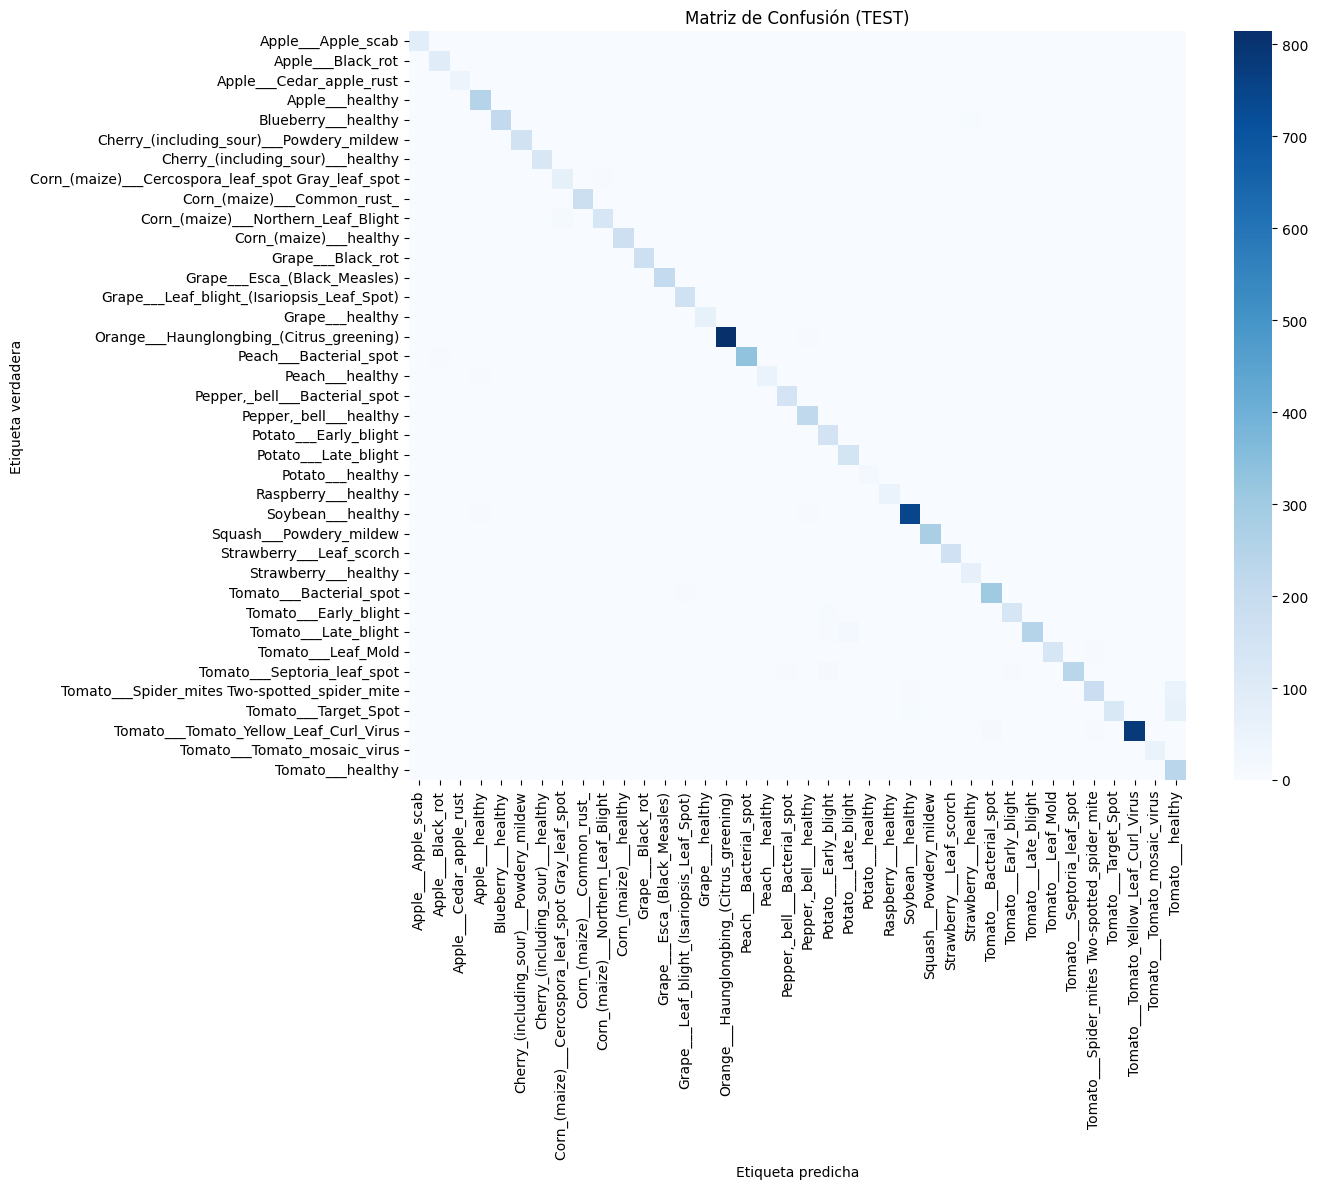

In [ ]:

# ========================
# EVALUACIÓN EN TEST
# ========================
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes

# Reporte
print("Classification Report (TEST):")
print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))

# Matriz de Confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=False, fmt="d", cmap="Blues",
            xticklabels=list(test_generator.class_indices.keys()),
            yticklabels=list(test_generator.class_indices.keys()))
plt.title("Matriz de Confusión (TEST)")
plt.ylabel("Etiqueta verdadera")
plt.xlabel("Etiqueta predicha")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
